In [1]:
suppressPackageStartupMessages({
  library(conos)
  library(pagoda2)
  library(Seurat)
  library(dplyr)
  library(ggplot2)
})

In [2]:
getwd()

[1] "/home/hsarkar/Projects/neuroblastoma_analysis/notebook/With_Ribosom"

In [3]:
tumor.obj = readRDS(
    '/home/meisl/Workplace/neuroblastoma/ThMYCN_210610/conos/conos/all.tumor_conos.rds')

In [4]:
tumor.obj$samples %>% names

[1] "het1_tumor"  "het2_tumor"  "homo1_tumor" "homo2_tumor" "homo3_tumor"

In [5]:
grep(
    pattern = "^rpl",
    x = colnames(tumor.obj$samples$het1_tumor$misc$rawCounts),
    value = T,
    ignore.case = T
)

[1] "Rpl7"       "Rpl31"      "Rpl37a"     "Rpl7a"      "Rpl12"     
 [6] "Rpl35"      "Rpl39"      "Rpl10"      "Rpl36a"     "Rpl22l1"   
[11] "Rpl34"      "Rpl11"      "Rpl22"      "Rpl9"       "Rpl5"      
[16] "Rplp0"      "Rpl6"       "Rpl21"      "Rpl32"      "Rpl28"     
[21] "Rpl13a"     "Rpl18"      "Rpl27a"     "Rplp2"      "Rpl41"     
[26] "Rpl18a"     "Rpl13"      "Rpl15"      "Rpl36a-ps1" "Rpl10-ps3" 
[31] "Rplp1"      "Rpl4"       "Rpl29"      "Rpl14"      "Rpl26"     
[36] "Rpl23a"     "Rpl9-ps1"   "Rpl23"      "Rpl19"      "Rpl27"     
[41] "Rpl38"      "Rpl10l"     "Rpl36al"    "Rpl37"      "Rpl30"     
[46] "Rpl8"       "Rpl3"       "Rpl39l"     "Rpl35a"     "Rpl24"     
[51] "Rpl3l"      "Rpl10a"     "Rpl7l1"     "Rpl36"      "Rpl7a-ps5" 
[56] "Rpl36-ps4"  "Rpl27-ps3"  "Rpl17"      "Rpl9-ps6"   "Rpl13a-ps1"

In [6]:
lapply(tumor.obj$samples, function(x){dim(x$misc$rawCounts)})

$het1_tumor
[1] 12874 31400

$het2_tumor
[1]  6936 31400

$homo1_tumor
[1]  6940 31400

$homo2_tumor
[1]  4267 31400

$homo3_tumor
[1] 11824 31400

In [7]:
s.objs = lapply(tumor.obj$samples, function(x){
  #raw.count = x$misc$rawCounts
    SR = CreateSeuratObject(counts = t(x$misc$rawCounts))
    SR[["percent.mt"]] <- PercentageFeatureSet(SR, pattern = "^mt-")
    SR <- subset(SR, 
                 subset = nFeature_RNA > 200 & nFeature_RNA < 7000 & percent.mt < 25)
    
    SR <- NormalizeData(SR)
    return(SR)
    
#   mito.genes = grep(pattern = "^mt-", x = colnames(raw.count), value = TRUE, ignore.case = TRUE)
#   rpl.genes = grep(pattern = "^rpl", x = colnames(raw.count), value = TRUE, ignore.case = TRUE)
#   rps.genes = grep(pattern = "^rps", x = colnames(raw.count), value = TRUE, ignore.case = TRUE)
#   genes.removed = union(mito.genes, rpl.genes)
#   genes.removed = union(genes.removed, rps.genes)  
})

In [8]:
lapply(s.objs, dim)

$het1_tumor
[1] 31400 12856

$het2_tumor
[1] 31400  6833

$homo1_tumor
[1] 31400  6860

$homo2_tumor
[1] 31400  4058

$homo3_tumor
[1] 31400 11725

In [9]:
get_integration = function(obj.list){
    features <- SelectIntegrationFeatures(object.list = obj.list,nfeatures = obj.list[[]])
    anchors <- FindIntegrationAnchors(
        object.list = obj.list, 
        anchor.features = features
    )
    immune.combined <- IntegrateData(anchorset = anchors)
    DefaultAssay(immune.combined) <- "integrated"

    # Run the standard workflow for visualization and clustering
    immune.combined <- ScaleData(immune.combined, verbose = FALSE)
    immune.combined <- RunPCA(immune.combined, npcs = 30, verbose = FALSE)
    immune.combined <- RunUMAP(immune.combined, reduction = "pca", dims = 1:30)
    immune.combined <- FindNeighbors(immune.combined, reduction = "pca", dims = 1:30)
    immune.combined <- FindClusters(immune.combined, resolution = 0.5)
    
    return(immune.combined)
}

In [10]:
features = SelectIntegrationFeatures(
    s.objs
)
s.obj.scaled = lapply(
    X = s.objs,
    FUN = function(x){
        x = ScaleData(x, features = features, verbose = FALSE)
        x = RunPCA(x, features = features, verbose = FALSE)
    }
)

anchors = FindIntegrationAnchors(
    object.list = s.obj.scaled,
    reference = c(1,3),
    reduction = 'rpca',
    dims = 1:50,
    
)

combined = IntegrateData(
    anchorset = anchors,
    dims = 1:50,
    features = rownames(s.objs)
)

No variable features found for object1 in the object.list. Running FindVariableFeatures ...

No variable features found for object2 in the object.list. Running FindVariableFeatures ...

No variable features found for object3 in the object.list. Running FindVariableFeatures ...

No variable features found for object4 in the object.list. Running FindVariableFeatures ...

No variable features found for object5 in the object.list. Running FindVariableFeatures ...

Computing 2000 integration features

No variable features found for object1 in the object.list. Running FindVariableFeatures ...

No variable features found for object2 in the object.list. Running FindVariableFeatures ...

No variable features found for object3 in the object.list. Running FindVariableFeatures ...

No variable features found for object4 in the object.list. Running FindVariableFeatures ...

No variable features found for object5 in the object.list. Running FindVariableFeatures ...

Scaling features for provided obj

In [11]:
combined <- ScaleData(combined, verbose = FALSE)
combined <- RunPCA(combined, npcs = 30, verbose = FALSE)
combined <- RunUMAP(combined, reduction = "pca", dims = 1:30)
combined <- FindNeighbors(combined, reduction = "pca", dims = 1:30)
combined <- FindClusters(combined, resolution = 0.5)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
22:28:48 UMAP embedding parameters a = 0.9922 b = 1.112

22:28:49 Read 42332 rows and found 30 numeric columns

22:28:49 Using Annoy for neighbor search, n_neighbors = 30

22:28:49 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

22:28:56 Writing NN index file to temp file /tmp/RtmpYJOnLk/file67d619c280b5

22:28:56 Searching Annoy index using 1 thread, search_k = 3000

22:29:13 Annoy recall = 100%

22:29:14 Commencing smooth kNN distance calibration using 1 thread

22:29:17 Initializing fr

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 42332
Number of edges: 1366083

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8960
Number of communities: 19
Elapsed time: 16 seconds


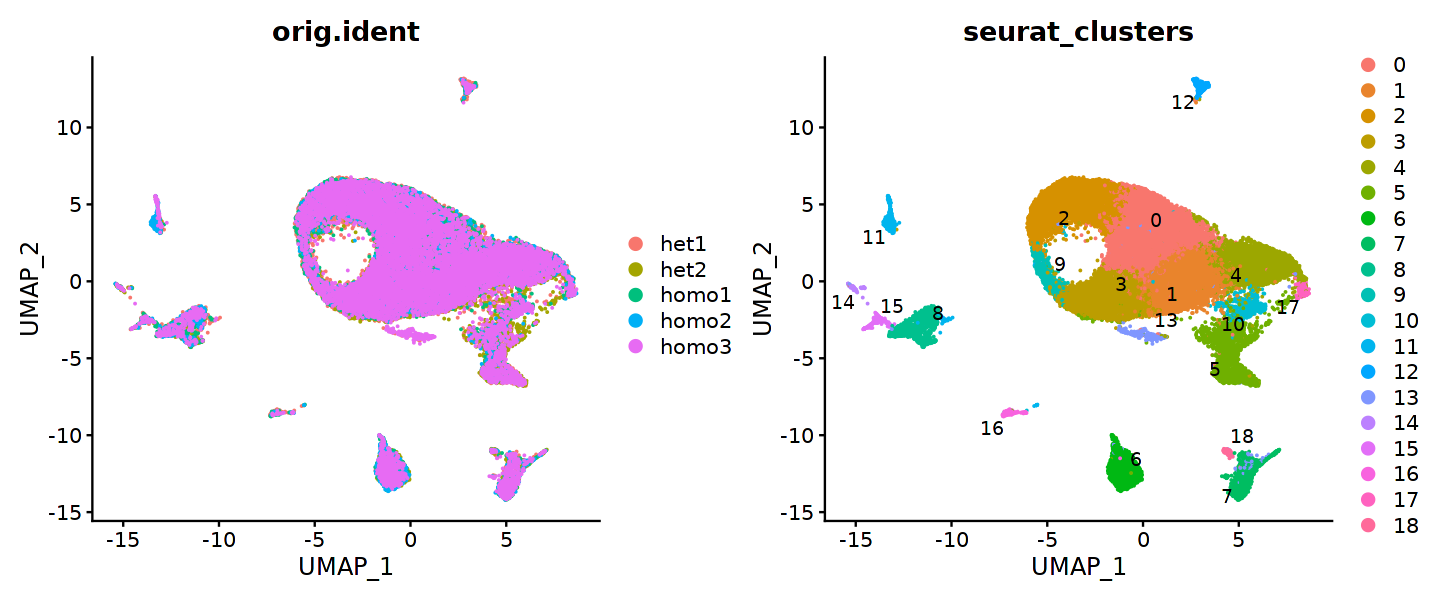

In [12]:
options(repr.plot.height=5, repr.plot.width=12, res=150 ) 
p1 <- DimPlot(combined, reduction = "umap",group.by='orig.ident')
p2 <- DimPlot(combined, 
              group.by = 'seurat_clusters',
              reduction = "umap", label = TRUE, repel = TRUE)
p1 + p2

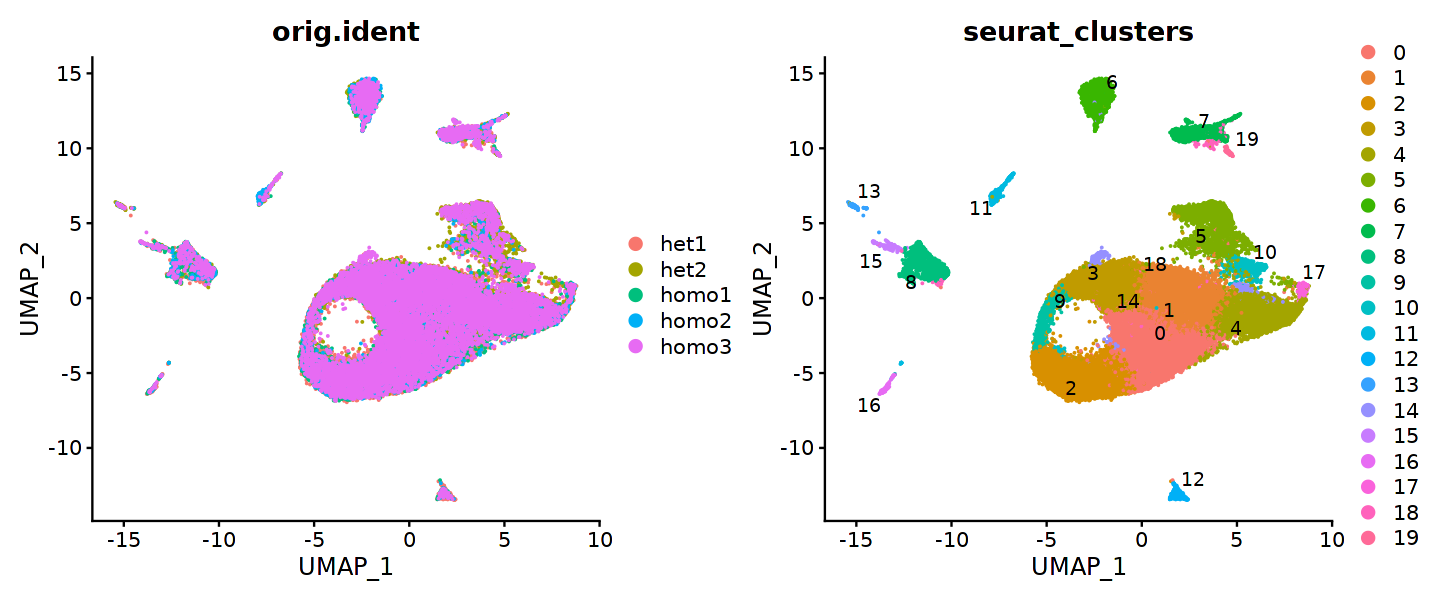

In [10]:
options(repr.plot.height=5, repr.plot.width=12, res=150 ) 
p1 <- DimPlot(combined, reduction = "umap",group.by='orig.ident')
p2 <- DimPlot(combined, 
              group.by = 'seurat_clusters',
              reduction = "umap", label = TRUE, repel = TRUE)
p1 + p2

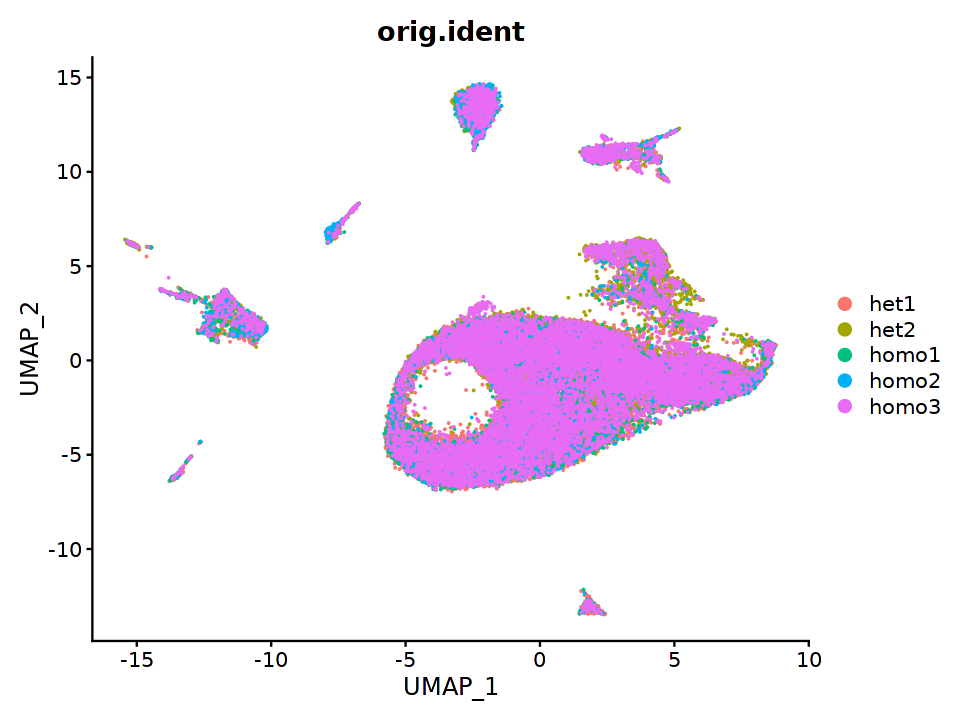

In [137]:
DimPlot(combined, reduction = "umap",group.by='orig.ident')

In [144]:
combined$orig.ident2 = 'heterozygous'
combined$orig.ident2[grep('homo', combined$orig.ident)] = 'hemizygous'

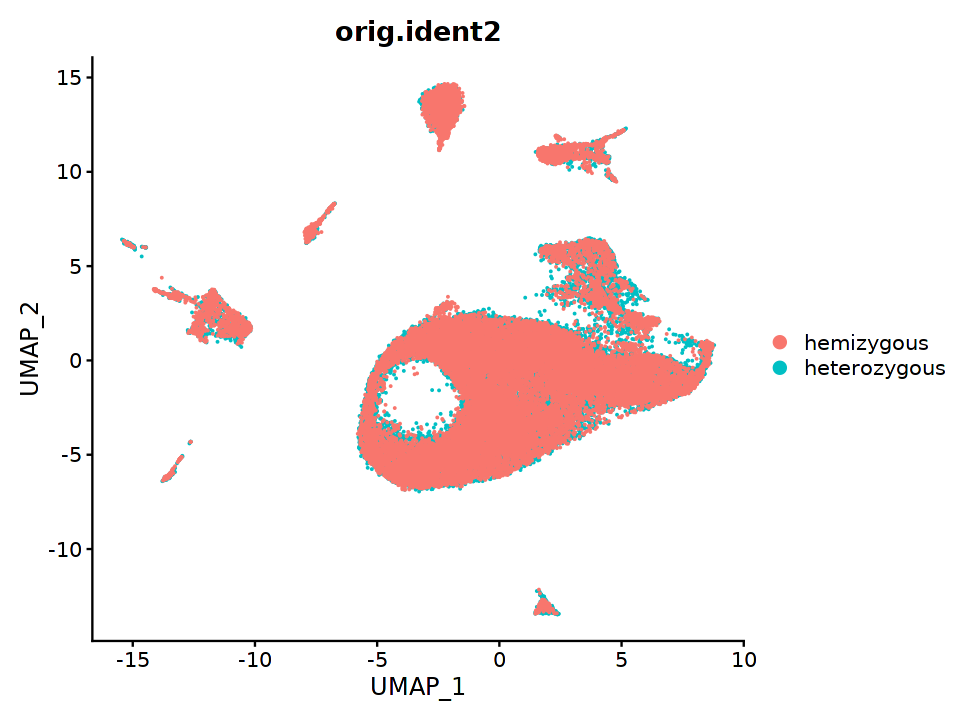

In [146]:
DimPlot(combined, reduction = "umap",group.by='orig.ident2')

In [97]:
annotations.df = openxlsx::read.xlsx(
    '/home/hsarkar/Adrenal_samples/2022-03-14_Annotations_5_Samples.xlsx')

In [74]:
dotplot_df = openxlsx::read.xlsx(
    '/home/hsarkar/Adrenal_samples/2022-03-17_shortdotplot_5_Samples.xlsx')

In [75]:
dotplot_df 

,Gene,Annotation
,<chr>,<chr>
1,MYCN,Sympathoblasts 1
2,NEFL,Sympathoblasts 2
3,CDC20,Sympathoblasts 3
4,TOP2A,Sympathoblasts 4
5,ASPM,Sympathoblasts 5
6,CHGA,Sympathoblasts 6
7,TH,Chromaffin
8,PTPRS,Immature ADRN
9,MGP,Mesenchymal


In [90]:
DefaultAssay(combined) = 'RNA'

In [95]:
combined = ScaleData(combined)

Centering and scaling data matrix



In [96]:
combined@assays$RNA@scale.data %>% head

,het1_tumor_AAACCCAAGCTTTCCC-1,het1_tumor_AAACCCAAGGCGTTAG-1,het1_tumor_AAACCCACAATCTCGA-1,het1_tumor_AAACCCACACCAAAGG-1,het1_tumor_AAACCCAGTCGAACAG-1,het1_tumor_AAACCCATCACATCAG-1,het1_tumor_AAACCCATCCAAAGGG-1,het1_tumor_AAACCCATCGCTGTCT-1,het1_tumor_AAACCCATCGGCTGAC-1,het1_tumor_AAACCCATCTATACTC-1,⋯,homo3_tumor_TTTGTTGCAGACGCTC-1,homo3_tumor_TTTGTTGCAGCCGTCA-1,homo3_tumor_TTTGTTGCATGAGTAA-1,homo3_tumor_TTTGTTGGTATCCTTT-1,homo3_tumor_TTTGTTGGTCACGCTG-1,homo3_tumor_TTTGTTGGTCATCAGT-1,homo3_tumor_TTTGTTGGTCCAGGTC-1,homo3_tumor_TTTGTTGGTCCGTACG-1,homo3_tumor_TTTGTTGTCAGGAAGC-1,homo3_tumor_TTTGTTGTCGGTCATA-1
MYCN,-1.281484172,-0.019746586,-2.055949545,0.041168149,0.429769775,-0.080450927,0.649333633,-0.144489131,-2.055949545,0.105369463,⋯,0.564281102,1.041787663,0.224725872,0.392594214,-0.001423973,0.392668977,-0.243174030,0.380906499,1.072111408,-0.045992490
Xkr4,-0.194194843,5.538640184,-0.194194843,-0.194194843,-0.194194843,-0.194194843,5.003813436,7.516838767,-0.194194843,-0.194194843,⋯,-0.194194843,6.025210901,-0.194194843,4.787092639,-0.194194843,-0.194194843,-0.194194843,-0.194194843,-0.194194843,-0.194194843
Gm1992,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,⋯,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000
Gm37381,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,⋯,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000
Rp1,-0.004860328,-0.004860328,-0.004860328,-0.004860328,-0.004860328,-0.004860328,-0.004860328,-0.004860328,-0.004860328,-0.004860328,⋯,-0.004860328,-0.004860328,-0.004860328,-0.004860328,-0.004860328,-0.004860328,-0.004860328,-0.004860328,-0.004860328,-0.004860328
Sox17,-0.044912311,-0.044912311,10.000000000,-0.044912311,-0.044912311,-0.044912311,-0.044912311,-0.044912311,-0.044912311,-0.044912311,⋯,-0.044912311,-0.044912311,-0.044912311,-0.044912311,-0.044912311,-0.044912311,-0.044912311,-0.044912311,-0.044912311,-0.044912311


In [94]:
DotPlot(combined, 
        assay='RNA',
        features = unique(annotations.df$Gene) %>% stringr::str_to_title() %>% rev, 
        group.by='annot', 
        cols = c("lightgrey", "darkred"))+
coord_flip()+theme(axis.text.x = element_text(angle = 90, hjust = 1))

ERROR: Error in DoHeatmap(combined, features = dotplot_df$Gene[1:10]): No requested features found in the scale.data slot for the RNA assay.


In [77]:
annot = annotations.df$Annotation

In [80]:
combined$annot = annot[ combined$`integrated_snn_res.0.5` ]

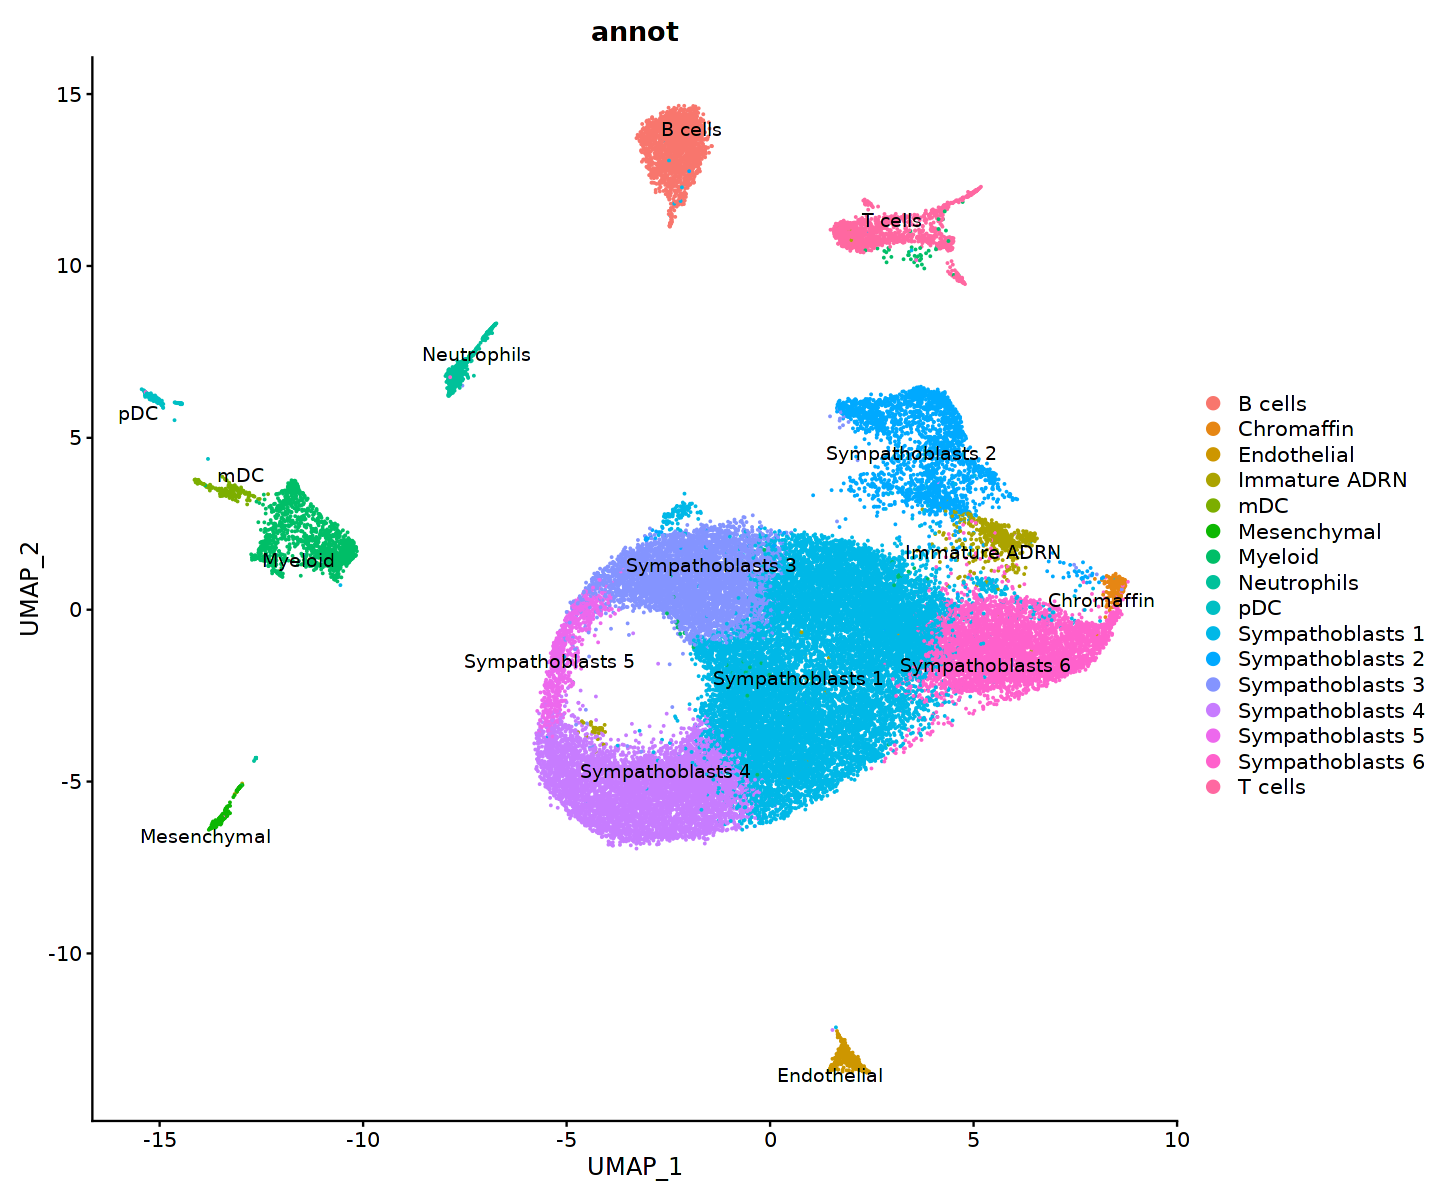

In [81]:
options(repr.plot.height=10, repr.plot.width=12, res=150 ) 

p2 <- DimPlot(combined, 
              group.by = 'annot',
              reduction = "umap", label = TRUE, repel = TRUE)
p2

In [106]:
combined.remove$annot = annot[ combined.remove$`integrated_snn_res.0.5` ]

In [107]:
avg.exp = AverageExpression(combined.remove, group.by = 'annot')$RNA

In [110]:
cor.exp <- as.data.frame(cor(avg.exp))
cor.exp$x <- rownames(cor.exp)

In [111]:
cor.df <- tidyr::gather(data = cor.exp, y, correlation, colnames(avg.exp))

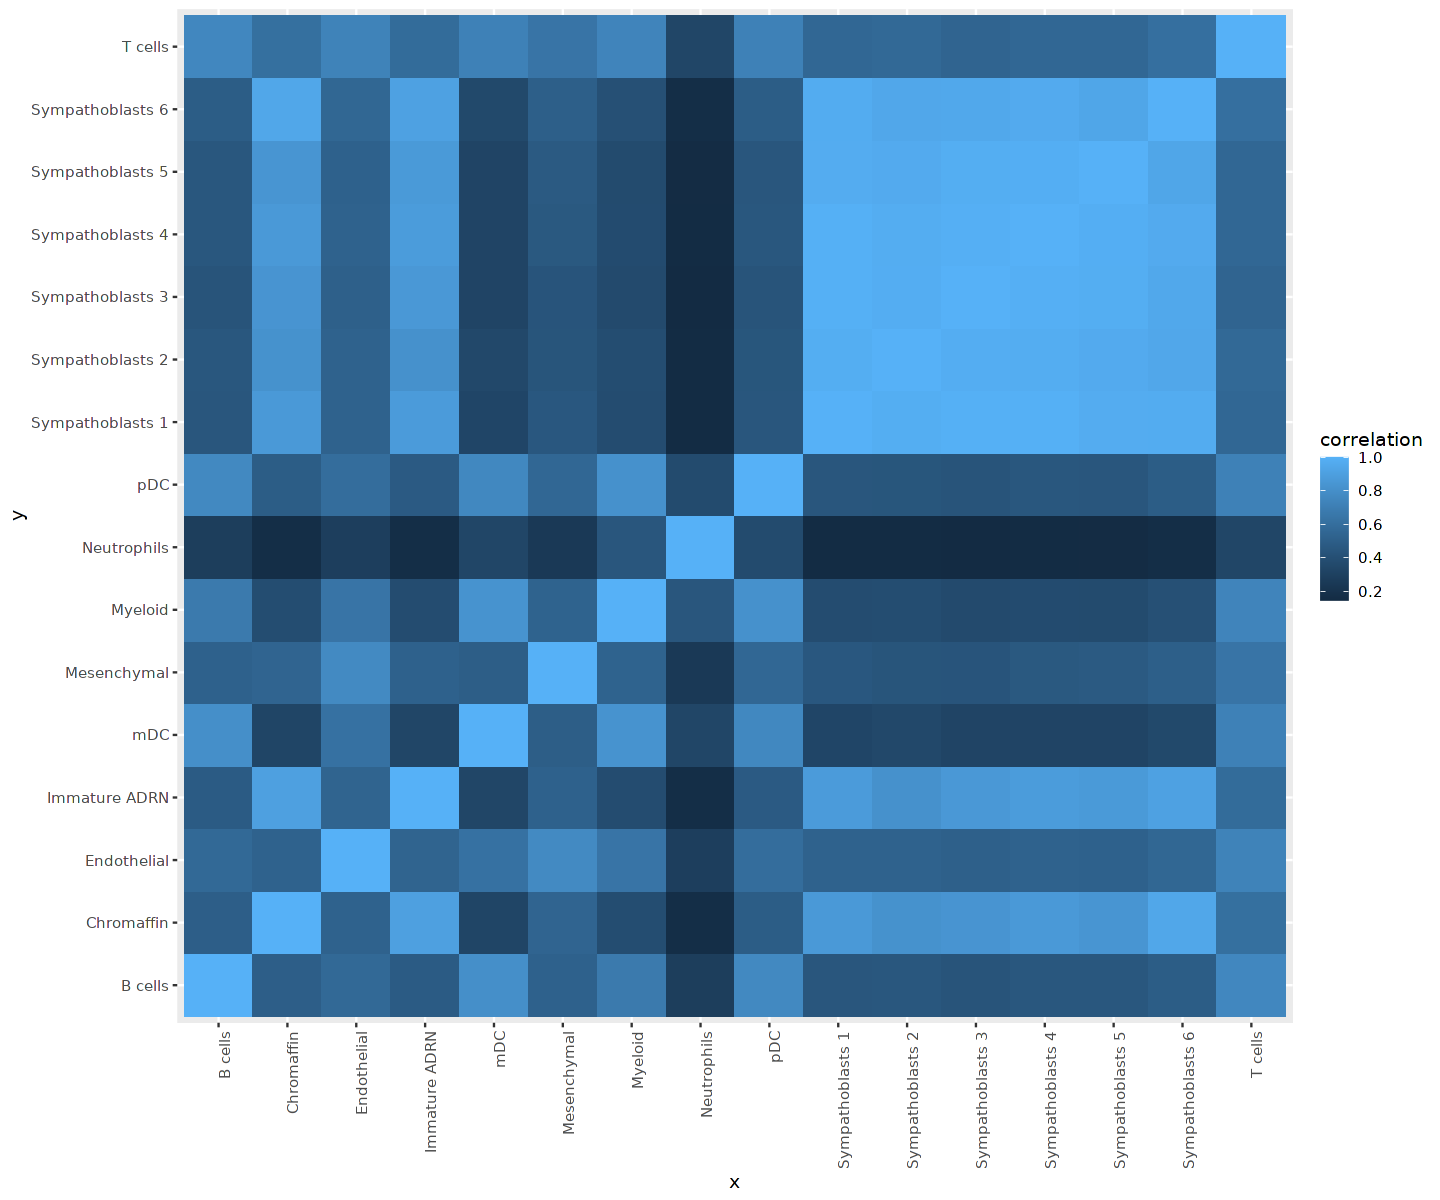

In [114]:
ggplot(cor.df, aes(x, y, fill = correlation)) +
  geom_tile() + theme(axis.text.x = element_text(angle = 90, hjust = 1))


In [64]:
intersect(
    unique(annotations.df$Gene) %>% stringr::str_to_title(),
    combined %>% rownames
    )

[1] "Nefl"    "Top2a"   "Cdc20"   "Chga"    "Ppia"    "Igkc"    "Cd3d"   
 [8] "Fcer1g"  "Aspm"    "S100a9"  "Cdh5"    "Siglech" "Syngr2"  "Mgp"    
[15] "Th"

In [65]:
unique(annotations.df$Gene) %>% stringr::str_to_title()

[1] "Nefl"    "Top2a"   "Cdc20"   "Chga"    "Ppia"    "Igkc"    "Cd3d"   
 [8] "Fcer1g"  "Aspm"    "Ptprs"   "S100a9"  "Cdh5"    "Siglech" "Syngr2" 
[15] "Mgp"     "Th"

In [76]:
dotplot_df[1,'Gene'] = 'PHOX2B'

In [77]:
dotplot_df

,Gene,Annotation
,<chr>,<chr>
1,PHOX2B,Sympathoblasts 1
2,NEFL,Sympathoblasts 2
3,CDC20,Sympathoblasts 3
4,TOP2A,Sympathoblasts 4
5,ASPM,Sympathoblasts 5
6,CHGA,Sympathoblasts 6
7,TH,Chromaffin
8,PTPRS,Immature ADRN
9,MGP,Mesenchymal


In [128]:
combined$annot = 
    factor(combined$annot , levels = dotplot_df$Annotation %>% unique )

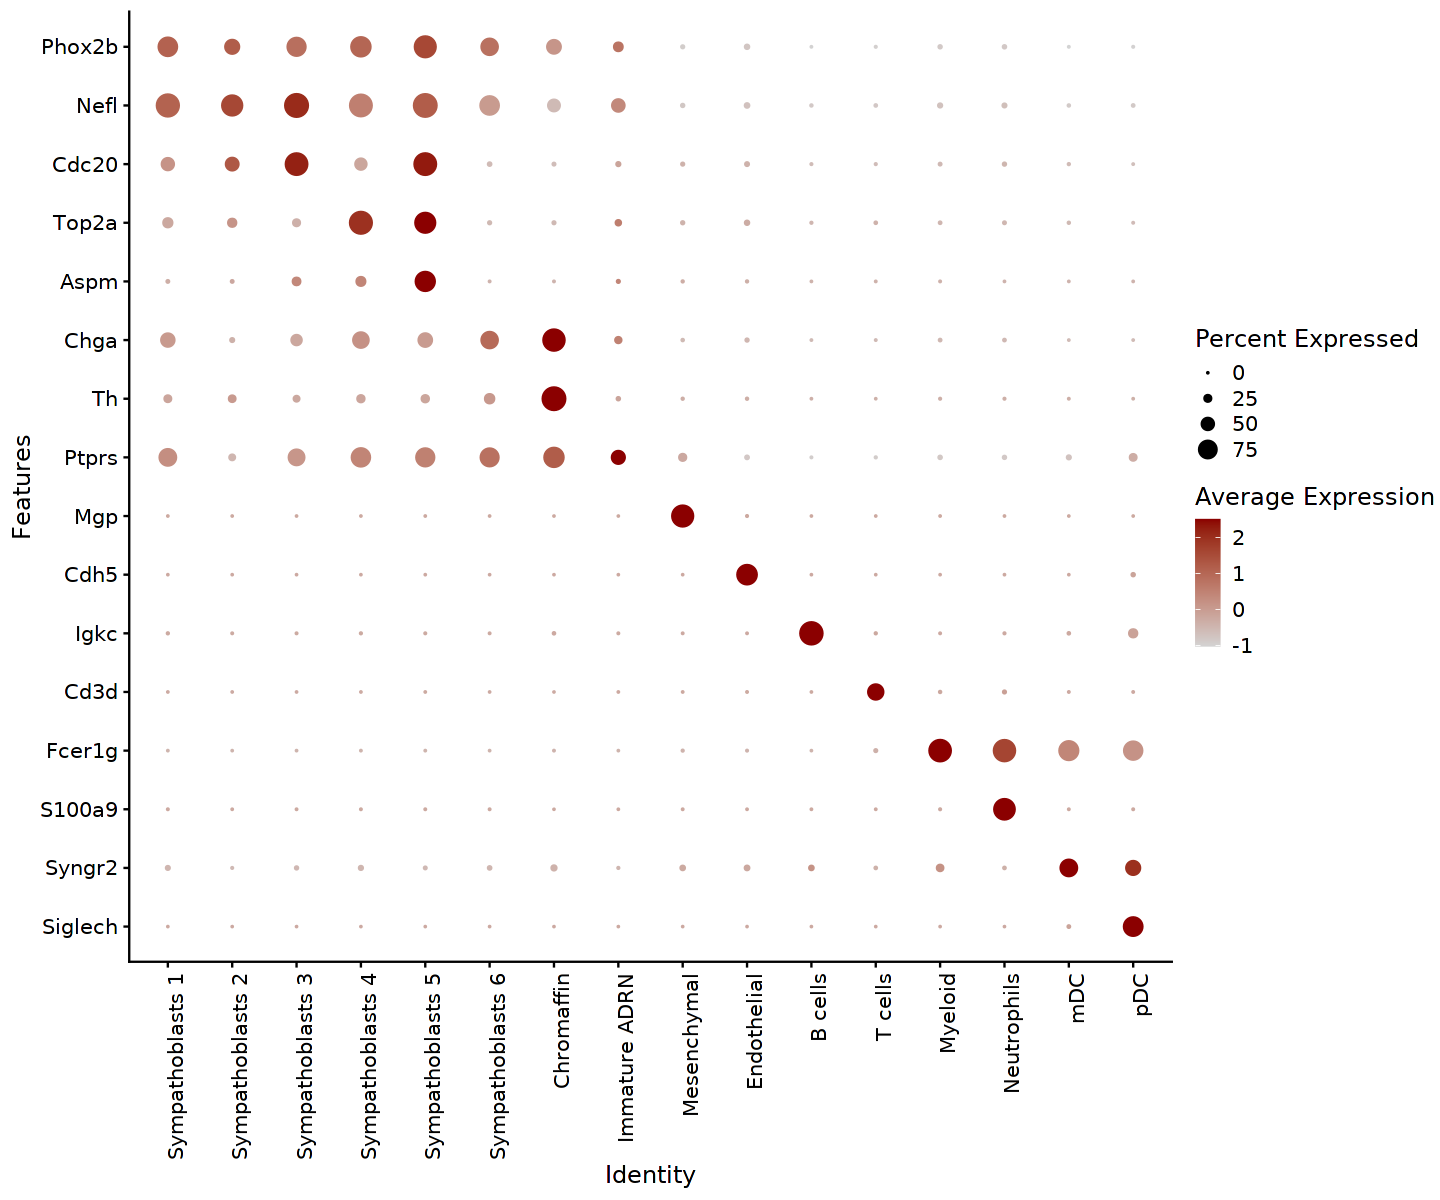

In [129]:
DotPlot(combined, 
        assay='RNA',
        features = unique(dotplot_df$Gene) %>% stringr::str_to_title() %>% rev, 
        group.by='annot', 
        cols = c("lightgrey", "darkred"))+
         coord_flip()+theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [131]:
adrn_sig = c('Sox11',
'Tcf4',
'Eml5',
'Ttc3',
'Meg3',
'Peg10',
'Atrx',
'Xist',
'Gm26917',
'Gm42418',
'Kcnq1ot1',
'Ptprs',
'Ncam1',
'Podxl2',
'Pcsk1n',
'Elavl3',
'MYCN'
)

In [132]:
combined.remove = AddModuleScore(
  object = combined.remove,
  assay = 'RNA',
  features = list(adrn_sig),
  name = 'adrn_score',
    ctrl = 5
)

In [ ]:
combined.remove$adrn_score1

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



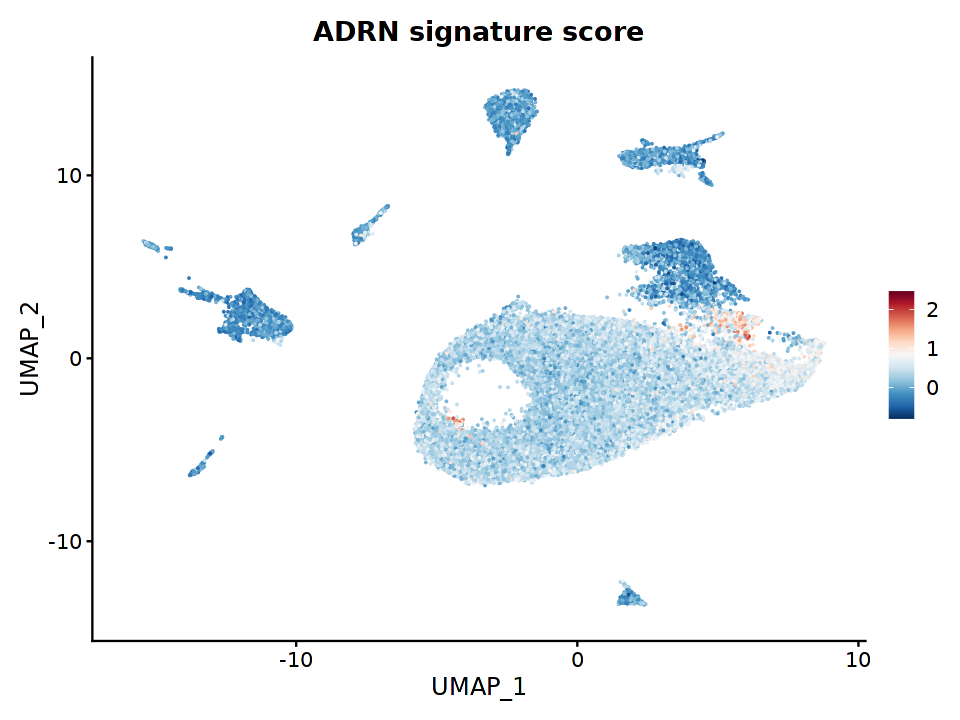

In [136]:
options(repr.plot.height=6, repr.plot.width=8, res=150 ) 
FeaturePlot(combined.remove,
            features = "adrn_score1", label = FALSE, repel = TRUE) +
            scale_colour_gradientn(
                colours = rev(
                    RColorBrewer::brewer.pal(n = 11, name = "RdBu"))) +
        ggtitle('ADRN signature score')


In [12]:
grep(pattern = "^rpl", x = rownames(combined), value = TRUE, ignore.case = TRUE)

character(0)

In [27]:
grep(pattern = "^mt-", x = rownames(combined@assays$RNA), value = TRUE, ignore.case = TRUE)

[1] "mt-Rnr1" "mt-Rnr2" "mt-Nd1"  "mt-Nd2"  "mt-Co1"  "mt-Co2"  "mt-Atp8"
 [8] "mt-Atp6" "mt-Co3"  "mt-Nd3"  "mt-Nd4l" "mt-Nd4"  "mt-Nd5"  "mt-Nd6" 
[15] "mt-Cytb"

In [28]:
grep(pattern = "^rps", x = rownames(combined@assays$RNA), value = TRUE, ignore.case = TRUE)

[1] "Rps6kc1"   "Rps21"     "Rps4x"     "Rps6ka6"   "Rps6ka3"   "Rps3a1"   
 [7] "Rps27"     "Rps20"     "Rps6"      "Rps8"      "Rps6ka1"   "Rps9"     
[13] "Rps5"      "Rps19"     "Rps16"     "Rps11"     "Rps17"     "Rps3"     
[19] "Rps13"     "Rps15a"    "Rps12"     "Rps15"     "Rps26"     "Rps24"    
[25] "Rps25"     "Rps27l"    "Rps27rt"   "Rpsa"      "Rps27a"    "Rps6kb1"  
[31] "Rps23"     "Rps7"      "Rps29"     "Rps6kl1"   "Rps6ka5"   "Rps19bp1" 
[37] "Rps6ka2"   "Rps2"      "Rps10"     "Rps28"     "Rps18"     "Rps14"    
[43] "Rps6kb2"   "Rps6ka4"   "Rps12-ps3"

In [23]:
lapply(tumor.obj$samples, function(x){dim(x$misc$rawCounts)})

$het1_tumor
[1] 12874 31400

$het2_tumor
[1]  6936 31400

$homo1_tumor
[1]  6940 31400

$homo2_tumor
[1]  4267 31400

$homo3_tumor
[1] 11824 31400

In [35]:
combined <- FindNeighbors(combined, reduction = "umap", dims=1:2)
combined <- FindClusters(combined, resolution = 0.3)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 42332
Number of edges: 943931

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9685
Number of communities: 28
Elapsed time: 2 seconds


In [31]:
mito.genes = grep(pattern = "^mt-", x = rownames(combined@assays$RNA), 
                  value = TRUE, ignore.case = TRUE)
rpl.genes = grep(pattern = "^rpl", x = rownames(combined@assays$RNA), 
                 value = TRUE, ignore.case = TRUE)
rps.genes = grep(pattern = "^rps", x = rownames(combined@assays$RNA), 
                 value = TRUE, ignore.case = TRUE)
genes.removed = union(mito.genes, rpl.genes)
genes.removed = union(genes.removed, rps.genes) 

In [ ]:
combined.remove = combined[setdiff(rownames(combined@assays$RNA), genes.removed),]

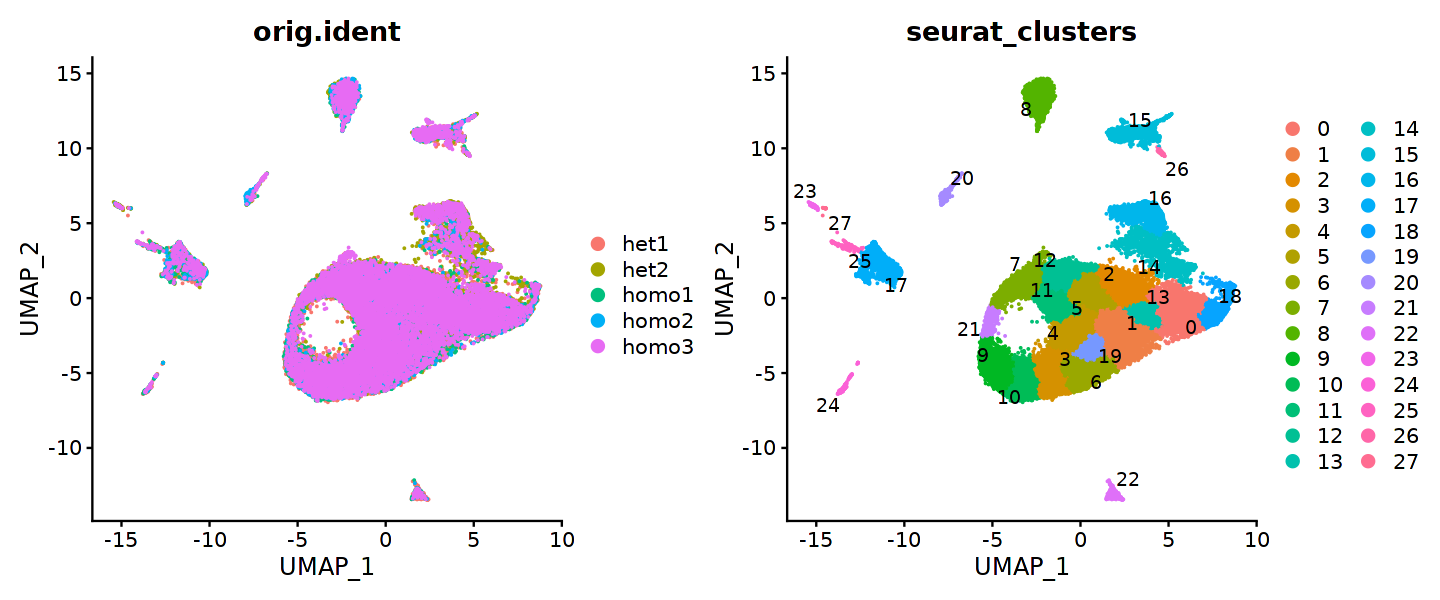

In [36]:
options(repr.plot.height=5, repr.plot.width=12, res=150 ) 
p1 <- DimPlot(combined, reduction = "umap",group.by='orig.ident')
p2 <- DimPlot(combined, 
              group.by = 'seurat_clusters',
              reduction = "umap", label = TRUE, repel = TRUE)
p1 + p2

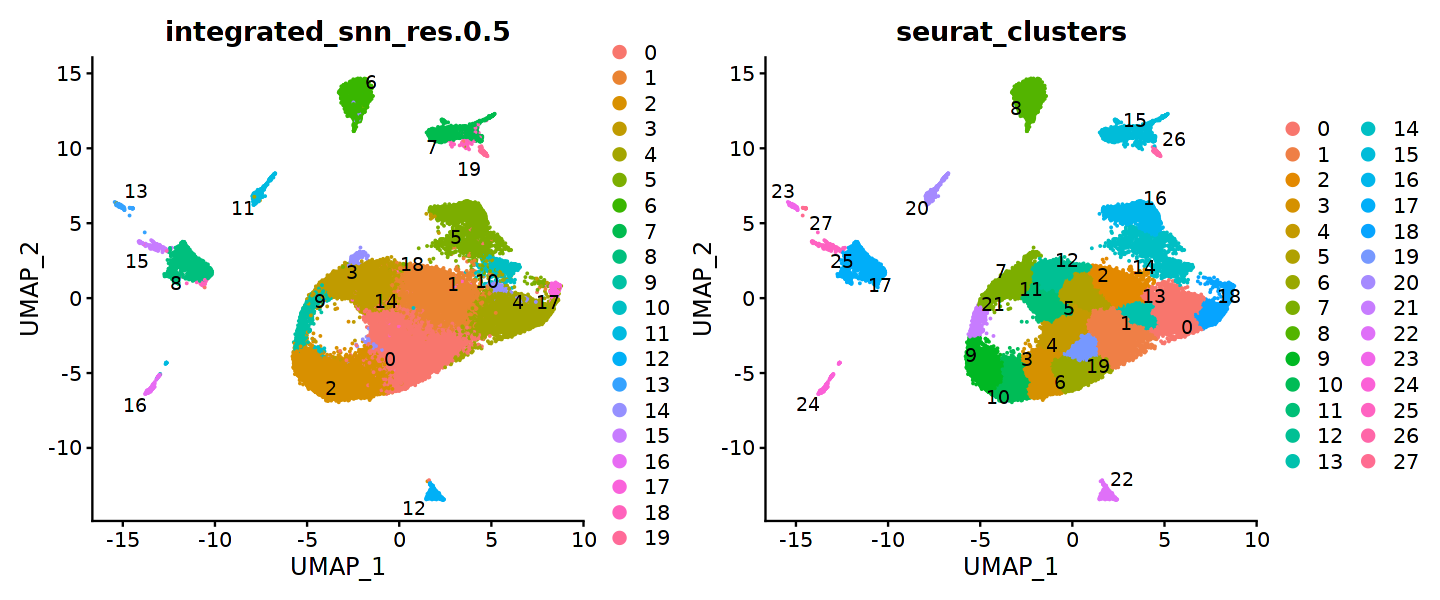

In [43]:
options(repr.plot.height=5, repr.plot.width=12, res=150 ) 
p1 <- DimPlot(combined, 
              group.by = 'integrated_snn_res.0.5',
              reduction = "umap", label = TRUE, repel = TRUE)
p2 <- DimPlot(combined, 
              group.by = 'seurat_clusters',
              reduction = "umap", label = TRUE, repel = TRUE)
p1 + p2

Warning message:
“Could not find Rpl7 in the default search locations, found in RNA assay instead”
Warning message:
“Could not find Rpl31 in the default search locations, found in RNA assay instead”
Warning message:
“Could not find Rpl37a in the default search locations, found in RNA assay instead”
Warning message:
“Could not find Rpl7a in the default search locations, found in RNA assay instead”
Warning message:
“Could not find Rpl12 in the default search locations, found in RNA assay instead”


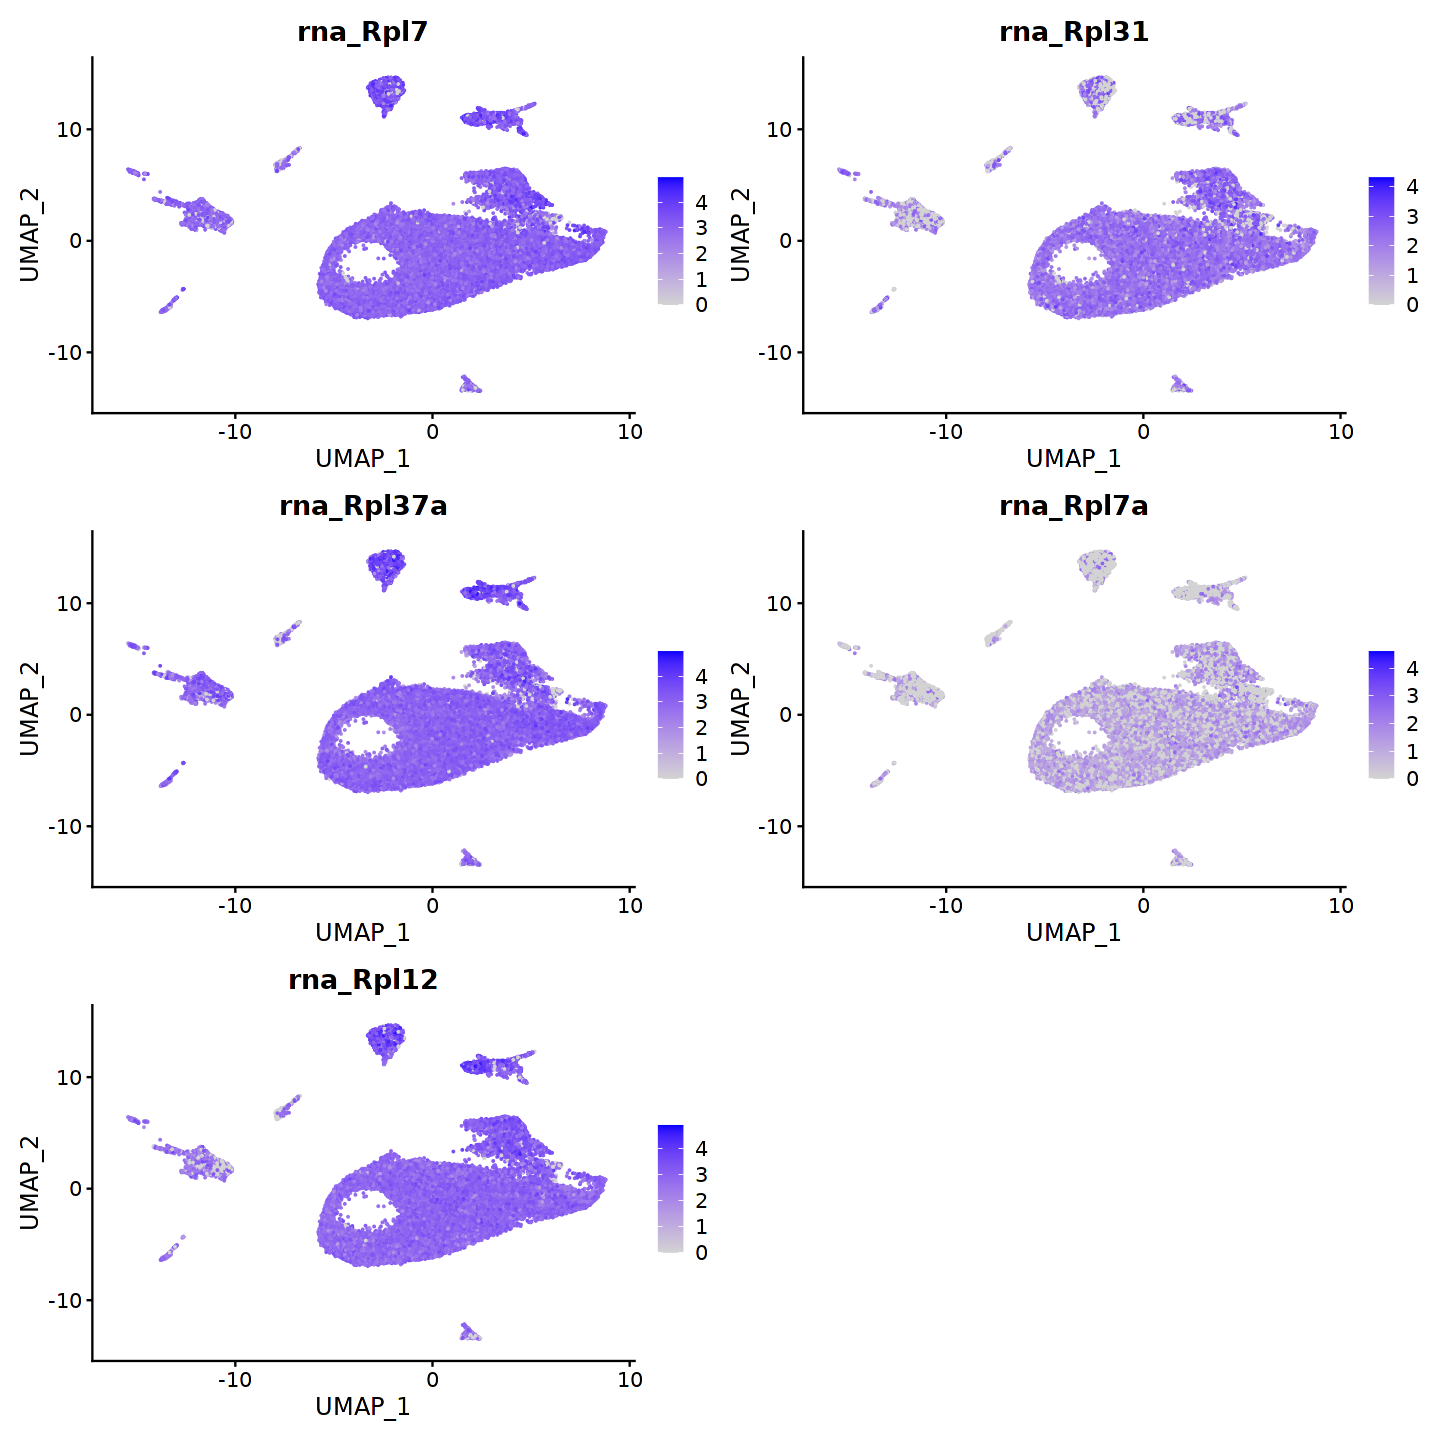

In [34]:
options(repr.plot.height=12, repr.plot.width=12, res=150 ) 
FeaturePlot(combined, features = c('Rpl7','Rpl31','Rpl37a','Rpl7a','Rpl12'))

In [38]:
save_seurat_as_pagoda=function(SR, fout, app.title = 'adrenal_sr_10K'){
    library(pagoda2)
    library(igraph)

    p2 <- basicP2proc(SR@assays$RNA@counts, n.cores = 20)

    go.env <- p2.generate.human.go(p2)


    #p2$clusters$PCA$seurat_cluster = as.factor(SR@meta.data$seurat_cluster)
    p2$clusters$PCA$seurat_cluster = as.factor(SR@meta.data$integrated_snn_res.0.5)
    
    names(p2$clusters$PCA$seurat_cluster) = rownames(SR@meta.data)

    p2$embeddings$PCA$tSNE = as.matrix(SR@reductions$umap@cell.embeddings)
        #p2$embeddings$PCA = as.matrix(p2$embeddings$PCA@cell.embeddings)

    p2$clusters$PCA$timepoint = as.factor(SR@meta.data$orig.ident)
    names(p2$clusters$PCA$timepoint) = rownames(SR@meta.data)

    p2$embeddings$PCA$tSNE = as.matrix(SR@reductions$umap@cell.embeddings)
        #p2$embeddings$PCA = as.matrix(p2$embeddings$PCA@cell.embeddings)


    n.cores=20

    cat('Calculating hdea...\n')
    hdea <- p2$getHierarchicalDiffExpressionAspects(
        type='PCA',
        clusterName='multilevel',
        z.threshold=3, 
        n.cores = n.cores)

    extraWebMetadata = NULL
    
    metadata.forweb <- list();
    metadata.forweb$timepoint <- p2.metadata.from.factor(
        p2$clusters$PCA$timepoint,
        displayname='timepoint'
    )
    metadata.forweb$leiden <- p2.metadata.from.factor(
        p2$clusters$PCA$seurat_cluster,
        displayname='seurat_cluster'
    )
    metadata.forweb$multilevel <- p2.metadata.from.factor(
        p2$clusters$PCA$multilevel,
        displayname='multilevel'
    )
    metadata.forweb <- c(metadata.forweb, extraWebMetadata)
    genesets <- hierDiffToGenesets(hdea)
    appmetadata = list(apptitle=app.title)
    cat('Making KNN graph...\n')
    #p2$makeGeneKnnGraph(n.cores=n.cores)
    p2w = make.p2.app(
        p2, 
        additionalMetadata = metadata.forweb, 
        geneSets = genesets, 
        dendrogramCellGroups = p2$clusters$PCA$multilevel, 
        show.clusters=F, 
        appmetadata = appmetadata)

    p2w$serializeToStaticFast(binary.filename = fout)    
}

In [39]:
save_seurat_as_pagoda(
    combined,
    glue::glue(
        '/home/hsarkar/Projects/neuroblastoma_analysis/data/with_ribo/',
        '5_samples.bin'
    ),
    app.title = '5_samples'
)

42332 cells, 31400 genes; normalizing ... 

Using plain model 

Winsorizing ... 

log scale ... 

done.


calculating variance fit ...

 using gam 

3412 overdispersed genes ... 3412

persisting ... 

done.

running PCA using 3000 OD genes .

.

.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


Estimating embeddings.


Warning message in p2$getEmbedding(type = "PCA", embeddingType = "tSNE", perplexity = perplexity, :
“Too many cells to pre-calculate correlation distances, switching to L2. Please consider using UMAP.”
running tSNE using 20 cores:




creating space of type angular done
adding data ... done
building index ... done
querying ... done


Calculating hdea...


Using multilevel clustering for PCA space




Making KNN graph...


NULL

In [40]:
combined.remove = combined[setdiff(rownames(combined@assays$RNA), genes.removed),]

In [41]:
combined.remove

An object of class Seurat 
33277 features across 42332 samples within 2 assays 
Active assay: integrated (1997 features, 1997 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [42]:
save_seurat_as_pagoda(
    combined.remove,
    glue::glue(
        '/home/hsarkar/Projects/neuroblastoma_analysis/data/with_ribo/',
        '5_samples_removed.bin'
    ),
    app.title = '5_samples_removed'
)

42332 cells, 31280 genes; normalizing ... 

Using plain model 

Winsorizing ... 

log scale ... 

done.


calculating variance fit ...

 using gam 

3278 overdispersed genes ... 3278

persisting ... 

done.

running PCA using 3000 OD genes .

.

.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


Estimating embeddings.


Warning message in p2$getEmbedding(type = "PCA", embeddingType = "tSNE", perplexity = perplexity, :
“Too many cells to pre-calculate correlation distances, switching to L2. Please consider using UMAP.”
running tSNE using 20 cores:




creating space of type angular done
adding data ... done
building index ... done
querying ... done
Calculating hdea...


Using multilevel clustering for PCA space




Making KNN graph...


NULL

## Velocity

In [ ]:
combined.remove$annot = annot[ combined.remove$`integrated_snn_res.0.5` ]

In [155]:
combined.remove$annot = 
    factor(combined.remove$annot , levels = dotplot_df$Annotation %>% unique )

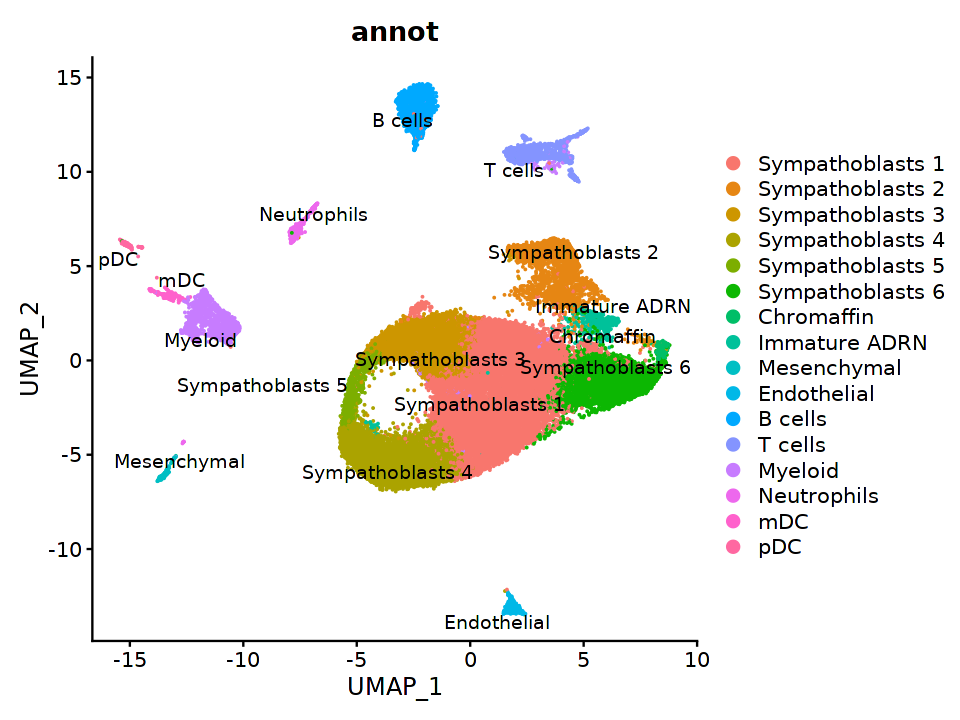

In [156]:
options(repr.plot.height=6, repr.plot.width=8, res=150 ) 

p2 <- DimPlot(combined.remove, 
              group.by = 'annot',
              reduction = "umap", label = TRUE, repel = TRUE)
p2

In [86]:
source('/home/hsarkar/Projects/neuroblastoma_analysis/scripts/SeuratRun.r')

Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning me

In [157]:
store_seurat(
    combined.remove,
    '/home/hsarkar/Projects/neuroblastoma_analysis/results/seurat_2/5_sample/'
)

Warning message in dir.create(out_dir, recursive = TRUE):
“'/home/hsarkar/Projects/neuroblastoma_analysis/results/seurat_2/5_sample' already exists”


In [ ]:
load_seurat = function(out_dir){
    meta_data = read.csv(
        glue::glue(
            out_dir,
            '/meta_data.csv'
        ),
        row.names = 1
    )

    pca_data = read.csv(
        glue::glue(
            out_dir,
            '/pca.csv'
        ),
        row.names = 1
    )
    
    count_mat = readMM(
        glue::glue(
            out_dir,
            '/counts.mtx'
        )
    )
    
    gene_names = read.csv(
        glue::glue(
            out_dir,
            '/genes.csv'
        ),
        header = F
    )$V1
    
    colnames(count_mat) = rownames(meta_data)
    rownames(count_mat) = gene_names
    
    combined.removed = CreateSeuratObject(
        counts = count_mat,
        meta.data = meta_data
    )
    
    pca_data = as.matrix(pca_data)
    rownames(pca_data) = rownames(meta_data)
    
    combined.removed <- ScaleData(combined.removed, verbose = FALSE)
    combined.removed <- RunPCA(combined.removed, npcs = 30, verbose = FALSE)
    combined.removed <- RunUMAP(combined.removed, reduction = "pca", dims = 1:30)
    
    combined.removed@reductions$pca@cell.embeddings = pca_data
    combined.removed@reductions$umap@cell.embeddings = 
        as.matrix(meta_data[,c('UMAP_1','UMAP_2')])
    
    return(combined.removed)
    
}

In [13]:
out_dir = '/home/hsarkar/Projects/neuroblastoma_analysis/results/seurat_2/5_sample/'

In [14]:
count_mat = readMM(
    glue::glue(
        out_dir,
        '/counts.mtx'
    )
)

In [44]:
meta_data = read.csv(
    glue::glue(
        out_dir,
        '/meta_data.csv'
    ),
    row.names = 1
)

pca_data = read.csv(
    glue::glue(
        out_dir,
        '/pca.csv'
    )
)

In [20]:
meta_data %>% dim

[1] 42332    11

In [35]:
gene_names = read.csv(
    glue::glue(
        out_dir,
        '/genes.csv'
    ),
    header = F
)$V1

In [38]:
gene_names %>% length

[1] 31280

In [15]:
count_mat %>% dim

[1] 31280 42332

In [46]:
pca_data %>% dim

[1] 42332    30

In [39]:
colnames(count_mat) = rownames(meta_data)
rownames(count_mat) = gene_names

In [40]:
combined.removed = CreateSeuratObject(
    counts = count_mat,
    meta.data = meta_data
)

In [47]:
pca_data = as.matrix(pca_data)
rownames(pca_data) = rownames(meta_data)

In [55]:
count_mat %>% colnames %>% head

[1] "het1_tumor_AAACCCAAGCTTTCCC-1" "het1_tumor_AAACCCAAGGCGTTAG-1"
[3] "het1_tumor_AAACCCACAATCTCGA-1" "het1_tumor_AAACCCACACCAAAGG-1"
[5] "het1_tumor_AAACCCAGTCGAACAG-1" "het1_tumor_AAACCCATCACATCAG-1"

In [61]:
#combined.removed <- FindVariableFeatures(combined.removed)
combined.removed <- ScaleData(combined.removed, verbose = FALSE)
combined.removed <- RunPCA(combined.removed, npcs = 30, verbose = FALSE)
combined.removed <- RunUMAP(combined.removed, reduction = "pca", dims = 1:30)

23:03:54 UMAP embedding parameters a = 0.9922 b = 1.112

23:03:54 Read 42332 rows and found 30 numeric columns

23:03:54 Using Annoy for neighbor search, n_neighbors = 30

23:03:54 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

23:04:02 Writing NN index file to temp file /tmp/RtmpYJOnLk/file67d63296714

23:04:02 Searching Annoy index using 1 thread, search_k = 3000

23:04:19 Annoy recall = 100%

23:04:20 Commencing smooth kNN distance calibration using 1 thread

23:04:23 Initializing from normalized Laplacian + noise

23:04:27 Commencing optimization for 200 epochs, with 1878050 positive edges

23:04:54 Optimization finished



In [63]:
combined.removed@reductions$pca@cell.embeddings = pca_data

In [69]:
combined.removed@reductions$umap@cell.embeddings = 
    as.matrix(meta_data[,c('UMAP_1','UMAP_2')])

In [78]:
combined.removed$annot = 
    factor(combined.removed$annot , levels = dotplot_df$Annotation %>% unique )

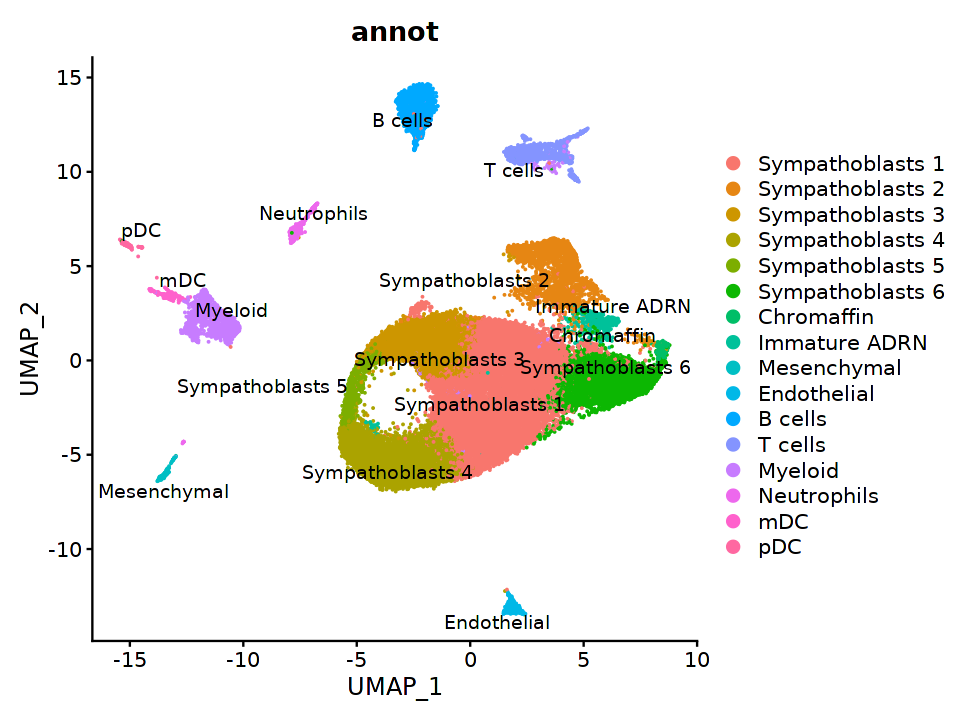

In [79]:
options(repr.plot.height=6, repr.plot.width=8, res=150 ) 

p2 <- DimPlot(combined.removed, 
              group.by = 'annot',
              reduction = "umap", label = TRUE, repel = TRUE)
p2

In [93]:
color.order = scales::hue_pal()(length(dotplot_df$Annotation %>% unique))
names(color.order) = dotplot_df$Annotation %>% unique %>% sort

In [96]:
color.order %>% length

[1] 16

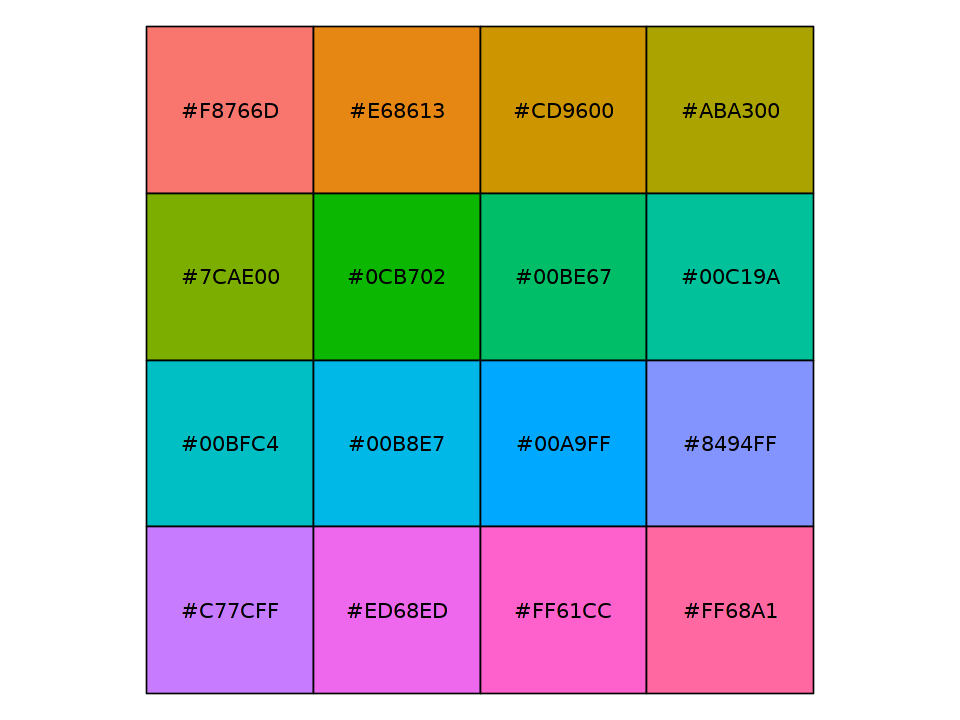

In [95]:
scales::show_col(color.order)

In [97]:
color.order %>% stack %>% 
    purrr::set_names(c('code','ind')) %>%
    write.csv(
        glue::glue(
             '/home/hsarkar/Projects/neuroblastoma_analysis/results/seurat_2/5_sample/',
            'color_code.csv'
        ),
    row.names =F
)

In [81]:
saveRDS(
    combined.removed,
    '/home/hsarkar/Projects/neuroblastoma_analysis/results/seurat_2/5_sample/seurat_obj.rds'
)

In [82]:
names(tumor.obj$samples)

[1] "het1_tumor"  "het2_tumor"  "homo1_tumor" "homo2_tumor" "homo3_tumor"

In [83]:
cell.names = colnames(combined.removed@assays$RNA@counts)
gene.names = rownames(combined.removed@assays$RNA@counts)

In [85]:
count.subsets = lapply( names(tumor.obj$samples), function(sample.name){
       s = cell.names[grep(sample.name, cell.names)]
       count = combined.removed@assays$RNA@counts[ , s ]
})

In [88]:
lapply(count.subsets, dim)

[[1]]
[1] 31280 12856

[[2]]
[1] 31280  6833

[[3]]
[1] 31280  6860

[[4]]
[1] 31280  4058

[[5]]
[1] 31280 11725

In [90]:
names(count.subsets) = names(tumor.obj$samples)

In [91]:
lapply(names(count.subsets), function(s){
    store_count_matrix(count.subsets[[s]], 
    paste0(
        '/home/hsarkar/Projects/neuroblastoma_analysis/results/seurat_2/5_sample_raw_counts/'
        ,
        s
    )
    )
})

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL